In [1]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder



## Starter med å lese inn CSV-filen som ble laget i data_cleaning-filen

In [2]:
ny_df = pd.read_csv('ferdig_dataframe.csv')

## Gjør om alle postnummer, kommunenummer, gårdsnummer til kategoriske variabler. Det er fordi dette ikke har noe numerisk betydning

In [3]:
combined_dataframe = ny_df

## Gjør om alle postnummer, kommunenummer, gårdsnummer til kategoriske variabler. Det er fordi dette ikke har noe numerisk betydning

combined_dataframe['eiendomByggested_0_adresse_postnr'] = combined_dataframe['eiendomByggested_0_adresse_postnr'].astype('category')
combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_kommunenummer'] = combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_kommunenummer'].astype(str)
combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_bruksnummer'] = combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_bruksnummer'].astype(str)
combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_gaardsnummer'] = combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_gaardsnummer'].astype(str)
combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_seksjonsnummer'] = combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_seksjonsnummer'].astype(str)
combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_festenummer'] = combined_dataframe['eiendomByggested_0_eiendomsidentifikasjon_festenummer'].astype(str)


# Identifiser numeriske og kategoriske kolonner
# Vi antar her at alle kolonner i 'common_columns' er enten numeriske eller kategoriske
# Konverter alle kategoriske kolonneverdier til strenger

In [4]:
numeric_columns = combined_dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = combined_dataframe.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
combined_dataframe[categorical_columns] = combined_dataframe[categorical_columns].astype(str)

## Opprett en preprocessing pipeline for numeriske data og kategoriske data

In [5]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Håndterer manglende verdier ved å bruke kolonnens gjennomsnitt
    ('scaler', StandardScaler())  # Standardiserer funksjoner ved å fjerne gjennomsnittet og skalere til enhetsvarians
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Fyller manglende verdier med en konstant
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Utfører one-hot encoding på kategoriske variabler
])

# Kombiner transformerne i en ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Preprocess dataene
combined_dataframe_processed = preprocessor.fit_transform(combined_dataframe)

## Finner gunstig mengde clusters

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


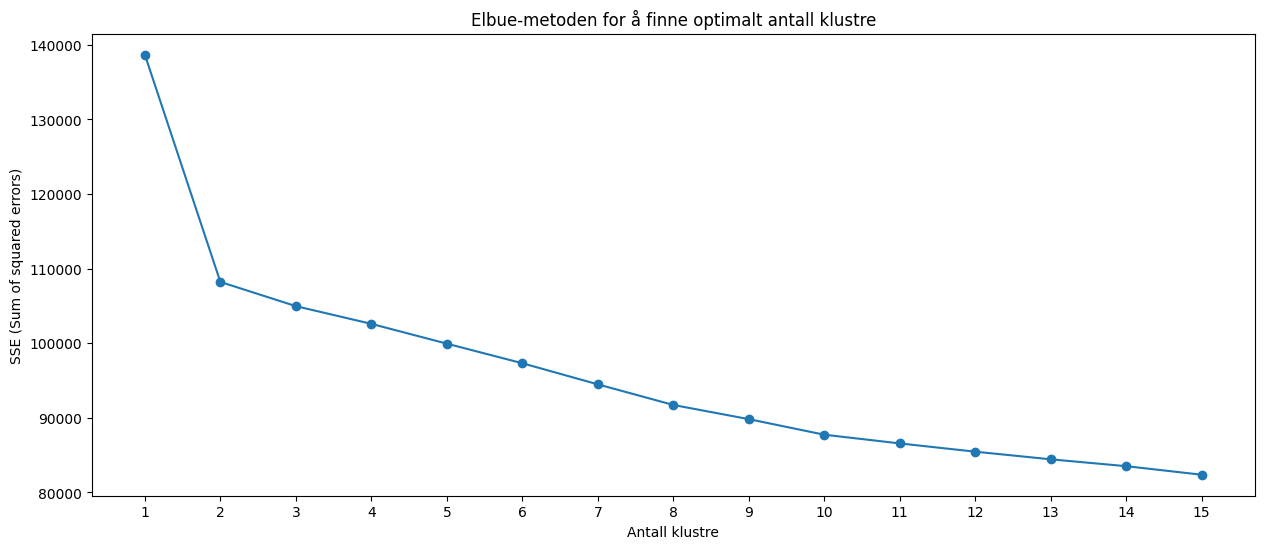

In [6]:
sse = []  # Sum of squared errors

# Test forskjellige antall klustre
for k in range(1, 21):  # For eksempel, tester fra 1 til 10 klustre
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_dataframe_processed)
    sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

# Plot Elbue-diagrammet
plt.figure(figsize=(20, 6))
plt.plot(range(1, 21), sse, marker='o')
plt.title('Elbue-metoden for å finne optimalt antall klustre')
plt.xlabel('Antall klustre')
plt.ylabel('SSE (Sum of squared errors)')
plt.xticks(range(1, 21))
plt.show()

## Definer og konfigurer KMeans-klustering

In [7]:
n_clusters = 15  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Utfør klustering på de forbehandlede dataene
kmeans.fit(combined_dataframe_processed)

# Legg til klusteretiketter til den opprinnelige DataFrame
combined_dataframe['cluster_label'] = kmeans.labels_

# Utforsk klustrene som før
print(combined_dataframe['cluster_label'].value_counts())

14    856
10    609
3     477
1     476
2     416
11    314
0     287
12    281
9     263
8     216
7     132
13    122
4      67
6      44
5       1
Name: cluster_label, dtype: int64


## Visualiserer i 3D

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


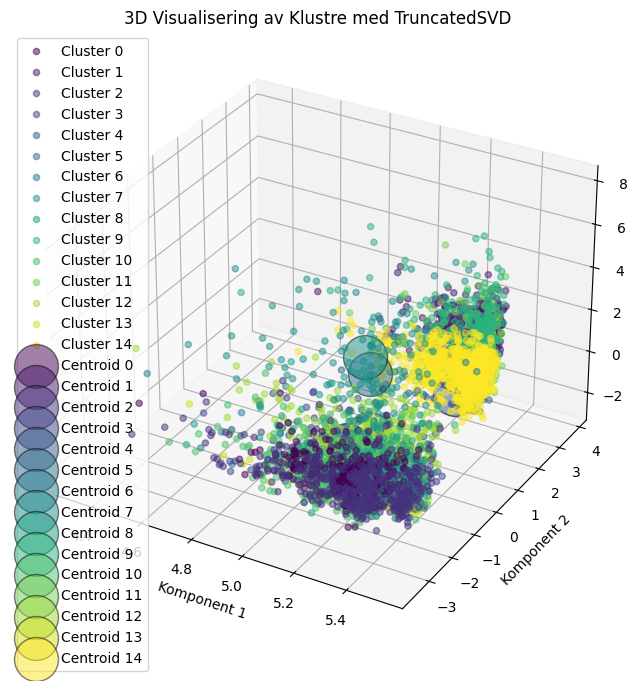

In [8]:


# Bruk TruncatedSVD for dimensjonsreduksjon til tre komponenter
svd = TruncatedSVD(n_components=60)
reduced_data = svd.fit_transform(combined_dataframe_processed)

# Øk antall klustre
n_clusters = 15  # For eksempel, øke til 10 klustre
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(combined_dataframe_processed)

# Få sentroidene og reduser dimensjonene for dem også
centroids = kmeans.cluster_centers_
centroids_reduced = svd.transform(centroids)

# Definer fargekart for klustre og sentroider
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Opprett et 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot datapunktene i 3D
for i in range(n_clusters):
    cluster_data = reduced_data[combined_dataframe['cluster_label'] == i]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], c=[colors[i]], label=f'Cluster {i}', alpha=0.5)

# Plot klustersentroidene i 3D med matchende farger og justerbar gjennomsiktighet
for i in range(n_clusters):
    ax.scatter(centroids_reduced[i, 0], centroids_reduced[i, 1], centroids_reduced[i, 2], c=[colors[i]], marker='o', s=1000, edgecolor='k', alpha=0.5, label=f'Centroid {i}')

# Tilføy titler og etiketter
ax.set_title('3D Visualisering av Klustre med TruncatedSVD')
ax.set_xlabel('Komponent 1')
ax.set_ylabel('Komponent 2')
ax.set_zlabel('Komponent 3')
plt.legend()

# Vis plottet
plt.show()

## Visualiserer i 2D

/usr/local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


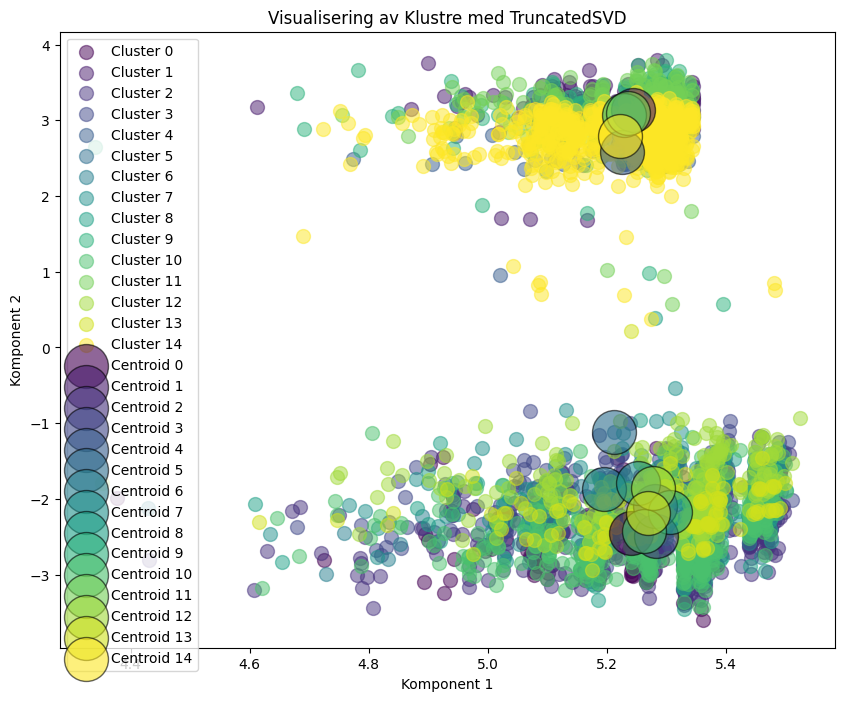

In [9]:
svd = TruncatedSVD(n_components=30)
reduced_data = svd.fit_transform(combined_dataframe_processed)

# Bruk KMeans for klustering
n_clusters = 15  # Antall klustre
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(combined_dataframe_processed)

# Få sentroidene og reduser dimensjonene for dem også
centroids = kmeans.cluster_centers_
centroids_reduced = svd.transform(centroids)

# Definer fargekart for klustre og sentroider
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

# Plot datapunktene med større radius og unike farger for hvert kluster
plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    cluster_data = reduced_data[combined_dataframe['cluster_label'] == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=[colors[i]], label=f'Cluster {i}', alpha=0.5, s=100)

# Plot klustersentroidene med matchende farger
for i in range(n_clusters):
    plt.scatter(centroids_reduced[i, 0], centroids_reduced[i, 1], c=[colors[i]], marker='o', s=1000, edgecolor='k', label=f'Centroid {i}', alpha=0.6)

# Tilføy titler og etiketter
plt.title('Visualisering av Klustre med TruncatedSVD')
plt.xlabel('Komponent 1')
plt.ylabel('Komponent 2')
plt.legend()

# Vis plottet
plt.show()

##Lager et nytt datasett der ytterligere kolonner fjernes

In [10]:
combined_dataframe_manuelt = combined_dataframe.drop(columns=["eiendomByggested_0_adresse_adresselinje1", "beskrivelseAvTiltak_foelgebrev", "beskrivelseAvTiltak_type_type_kodebeskrivelse","eiendomByggested_0_eiendomsidentifikasjon_bruksnummer", "eiendomByggested_0_eiendomsidentifikasjon_festenummer", "eiendomByggested_0_eiendomsidentifikasjon_seksjonsnummer"])
numeric_columns = combined_dataframe_manuelt.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = combined_dataframe_manuelt.select_dtypes(exclude=['int64', 'float64']).columns.tolist()


# Konverter alle kategoriske kolonneverdier til strenger
combined_dataframe_manuelt[categorical_columns] = combined_dataframe_manuelt[categorical_columns].astype(str)
combined_dataframe_manuelt.columns = [str(col) for col in combined_dataframe_manuelt.columns]

encoder = LabelEncoder()

# Utfør label encoding på den spesifikke kolonnen
for col in categorical_columns:
    combined_dataframe_manuelt[col] = encoder.fit_transform(combined_dataframe_manuelt[col])

# Tren et beslutningstre med de oppdaterte dataene

In [13]:
# Tren et beslutningstre med de oppdaterte dataene
y = combined_dataframe_manuelt['cluster_label']
X = combined_dataframe_manuelt.drop(columns=['cluster_label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Vis nøyaktigheten og feature importance
print(f"Nøyaktighet: {accuracy}")
feature_importance = tree.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance})
print(feature_importance_df.sort_values(by='importance', ascending=False).head())

Nøyaktighet: 0.8049671292914536
                                              feature  importance
45                                                  1    0.197387
14  rammebetingelser_arealdisponering_beregnetMaks...    0.119429
44                                                  0    0.085981
52                                                  8    0.077897
53                                                  9    0.077236


## Visualiserer det som beslutningstreet antar er de viktigste kolonnene

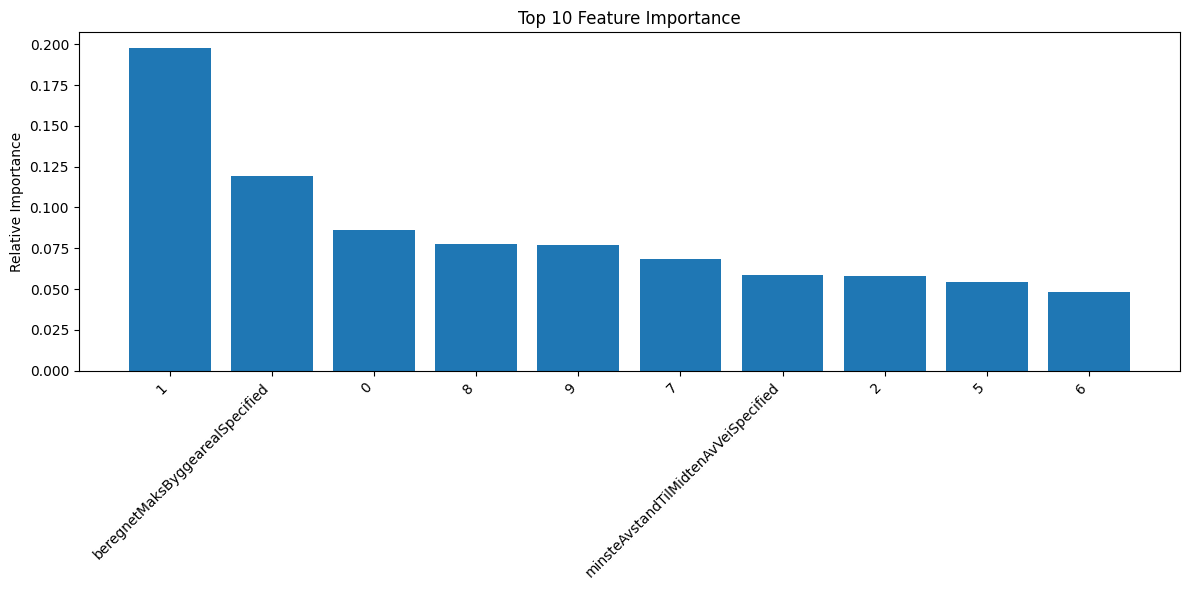

In [14]:
top_features = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

top_features['feature'] = top_features['feature'].apply(lambda x: x.split('_')[-1])

# Plot feature importance for de 10 viktigste features
plt.figure(figsize=(12, 6))
plt.title('Top 10 Feature Importance')
plt.bar(top_features['feature'], top_features['importance'], align='center')
plt.xticks(rotation=45, ha='right')  # Roterer etiketter 45 grader og justerer til høyre
plt.ylabel('Relative Importance')
plt.tight_layout()  # Justerer layout for å passe alle etiketter
plt.show()